In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

## Importing custom functions from different folder:

In [2]:
# Get the current directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
folder = 'Implementation'
data_folder = os.path.join(parent_dir, folder)

# Construct the full file path
file_ = 'utils_data'
full_path = os.path.join(data_folder, file_)
print(full_path)
print(data_folder)
sys.path.append(data_folder)  

# Load the functions from .py file  
try:
    from utils_data_multiple import load_multiple_data, plot_multiple_data, point_to_segment, cleaning_clustering_multiple_data
    from utils_data_multiple import plot_data
    from utils_data_multiple import saving_processed_mult_data, load_processed_mult_data, multiple_linear_transf  
    from utils_model_multiple import load_params, fitParamaters_mult
    #from utils_data import plot_velocity
    #from utils_model_multiple import numericalSimulation, ComputeFunctional, ComputeVel
    #from utils_model_multiple import generate_trajectory, plot_simulation, generate_trajectory_vel, optimize_Sigma, plot_multiple_trajectories, plotting_params
except ModuleNotFoundError as e:
    print("ModuleNotFoundError:", e)

/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation/utils_data
/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation


## Treating multiple subjects data

Motivation may be: 
- 0: playing alone
- 1: easy rival
- 2: hard rival 

The data is now clustered by motivation level, i.e. `dataTrajecetories-25-M1-C1`. We are also splitting the dataset depending on the playing modes: passing through and stopping. For each dataset moreover we have the four different trajectories.

The data is normalized, clustered in terms of motivation, playing mode and ordered by trajectory. 

We seek to find a paramater fitting for each subject, motivational state and playing mode, and trajectory. Then we can consider the mean for each case to fit the model for each subject and motivational state. 

We consider the mass to be the same at the begining of the movement, hence we are studying 3 motivational states x 2 playing modes parameters per player. 

We have 4 possible trajectories (the playing modes just modify the control function, since the effort is different). 

## Reproducing results

We can reproduce our results in this Notebook by setting the initial parameters as well as on the `main_multiple.py` file. 

Set the following parameters according to the study you wish to conduct: 
- `processing` when set to `True` it conducts the whole processing process from the raw data. This includes: 
    - `cleaning_clustering_multiple_data`: 
        - Cleaning the trajectories which do not cross the target and truncating the ones which do cross it. Also storing the optimal time in which they reach the target, $T^*$, stored in `idxrule` 
        - Classifying the data in 4 clusters, depending on the target they cross
    - `multiple_linear_transf`: 
        - Rotating the needed trajectories and scaling them in order to get normalized data
        - Computing the mean velocity and the velocity profiles for each trajectory

ATTENTION: This process takes more than 2 hours to be fully completed. 

- `fitting` when set to `True` the fitting of the parameters is conducted with the already processed data. This includes: 
    - `fitParamaters_mult`: 
        - Sequential approach: 
            1. Optimal movement duration: Generate the optimal trajectory by optimizing the Functional in terms of the time T 
            2. Optimal controller: generate the optimal trajectory with the optimal time duration by minimizing the functional in terms of the biomechanical parameters $(\alpha, \gamma, \varepsilon)$. 
            3. Stochastic optimization: generate the optimal trajectory with optimal time duration and biomechanical parameters by optimizing the Kolmogorov Sirnov estimate in terms of the sigma 
        - Saving the obtained parameters

- `plotting` when set to `True` all the trajectory plots and prints are explicitly shown on this Notebook
- `saving` when set to `True` all the plots and data processed is saved. 

In [11]:
processing = False
fitting = False
plotting = False
saving = False

### Loading data: 

In [4]:
cluster_points = [
        (10.5, 4.85),   # pt2
        (-11, -5),       # pt3  
        (10.5, 0),      # pt1    
        (-10.5, 1.25)  # pt0
    ]
n_clusters = 4

segments = point_to_segment(cluster_points, n_clusters)

In [15]:
if processing:
    print('Loading and processing data...')
    data_dict = load_multiple_data(first_subj = 25, last_subj = 37, 
                       file_names = 'dataTrajectories' )
    if plotting: 
        print('List with al the target segments:', segments)
        print('List with the two points of segment for cluster 0:', segments[0])
        print('Array with point target 1 for cluster 0:', segments[0][0])
        print('First coordinate of point target 1 for cluster 0:', segments[0][0][0])
        plot_multiple_data(data_dict)
    
    cleaned_data_dict, idxrule_dict = cleaning_clustering_multiple_data(data_dict, 
                                    segments, 
                                    first_subj = 25, last_subj = 37,
                                    save_dir = 'subject_plots')

    if saving: 
        saving_processed_mult_data(idxrule_dict=idxrule_dict, folder_name='clustered_multiple_data')
        saving_processed_mult_data(cleaned_data_dict = cleaned_data_dict, 
                                folder_name = 'clustered_multiple_data')
        
    scaled_data_dict, velocity_dict, results_dict = multiple_linear_transf(cleaned_data_dict, idxrule_dict, 
                            segments, 
                            first_subj = 25, last_subj = 37,
                            n_clusters = 4,
                            saving = True, 
                            save_dir = 'subject_plots_2')
    if saving: 
        saving_processed_mult_data(cleaned_data_dict = scaled_data_dict, 
                                folder_name = 'scaled_data')
        saving_processed_mult_data(cleaned_data_dict = velocity_dict, 
                                folder_name = 'velocity')
        saving_processed_mult_data(idxrule_dict = results_dict, 
                                folder_name = 'scaled_data')
        
    print('Fitting paramaters for the optimized trajectory...')   
    
    if fitting: 
        new_params, opt_sigma = fitParamaters_mult(scaled_data_dict,
                    idxrule_dict, 
                    results_dict,
                    segments, 
                    first_subj = 25, last_subj = 30,
                    n_clusters = 4, folder_name = 'fitted_trajectories_2', 
                    saving = saving)
    
elif fitting: 
    print('Loading processed data...')
    cleaned_data_dict, idxrule_dict = load_processed_mult_data(folder_name='clustered_multiple_data')
    scaled_data_dict, results_dict = load_processed_mult_data(folder_name='scaled_multiple_data') 
    print('Data loaded and processed :)')
    
    print('Fitting paramaters for the optimized trajectory...')   
    new_params, opt_sigma = fitParamaters_mult(scaled_data_dict,
                  idxrule_dict, 
                  results_dict,
                  segments, 
                  first_subj = 25, last_subj = 30,
                  n_clusters = 4, folder_name = 'fitted_trajectories_2', 
                  saving = saving)
    
else: 
    print('Loading fitted parameters...')
    params_loaded = load_params(folder_name = 'fitted_parameters')
    opt_sigma = load_params(folder_name = 'fitted_parameters_sigma')

Loading fitted parameters...
Loading the new parameters...
New parameters have been loaded successfully.
Loading the new parameters...
New parameters have been loaded successfully.


### Fitting the parameters

#### Loading fitted parameters

In [18]:
print(params_loaded.keys())
print(params_loaded[31].keys())
print(params_loaded[31]['31_21_cluster_2'].x)

dict_keys([25, 31, 36, 30, 29, 27, 26, 28, 35, 32, 33, 34])
dict_keys(['31_21_cluster_2', '31_12_cluster_1', '31_32_cluster_3', '31_32_cluster_2', '31_12_cluster_0', '31_21_cluster_3', '31_22_cluster_2', '31_31_cluster_3', '31_11_cluster_1', '31_11_cluster_0', '31_31_cluster_2', '31_22_cluster_3', '31_22_cluster_0', '31_11_cluster_3', '31_31_cluster_1', '31_31_cluster_0', '31_11_cluster_2', '31_22_cluster_1', '31_21_cluster_0', '31_32_cluster_1', '31_12_cluster_3', '31_12_cluster_2', '31_32_cluster_0', '31_21_cluster_1'])
[ 2.94100671  3.03937839 -3.19640915]


In [19]:
print(opt_sigma.keys())
print(opt_sigma[28].keys())
print(opt_sigma[28]['28_32_cluster_3'].x)

dict_keys([25, 31, 36, 30, 29, 27, 26, 28, 35, 32, 33, 34])
dict_keys(['28_32_cluster_3', '28_12_cluster_1', '28_21_cluster_2', '28_21_cluster_3', '28_12_cluster_0', '28_32_cluster_2', '28_11_cluster_1', '28_31_cluster_3', '28_22_cluster_2', '28_22_cluster_3', '28_31_cluster_2', '28_11_cluster_0', '28_31_cluster_1', '28_11_cluster_3', '28_22_cluster_0', '28_22_cluster_1', '28_11_cluster_2', '28_31_cluster_0', '28_12_cluster_3', '28_32_cluster_1', '28_21_cluster_0', '28_21_cluster_1', '28_32_cluster_0', '28_12_cluster_2'])
5.07244087283925


### Functions

In [28]:
def extract_all_parameters(params_dict):
    parameters = []
    for key in params_dict:
        for subkey in params_dict[key]:
            result = params_dict[key][subkey]
            if isinstance(result, dict) and 'x' in result:
                parameters.append(result['x'])
            else:
                parameters.append(result.x)
    return np.array(parameters)

In [82]:
# Extract parameters from both dictionaries
params_array = extract_all_parameters(params_loaded)
sigma_array = extract_all_parameters(opt_sigma)

print(params_array)
print(sigma_array)
print(len(params_array))
print(len(sigma_array))
print(sigma_array.shape)
print(params_array.shape)

[[ 2.96743234  3.05710788 -3.22127583]
 [ 2.97021722  3.05972711 -3.22615425]
 [ 2.90419684  3.02280277 -3.17654184]
 [ 3.2061852   3.1816124  -3.22311537]
 [ 3.00863195  3.09833158 -3.27948555]
 [ 2.94053683  3.03863067 -3.19066588]
 [ 3.14770828  3.12835078 -3.15672674]
 [ 2.95370643  3.07940919 -3.26372547]
 [ 2.87417684  2.97127306 -3.09971341]
 [ 3.1103499   3.10968916 -3.12021185]
 [ 2.91383992  3.03931987 -3.21086467]
 [ 3.06135955  3.05413818 -3.02696543]
 [ 3.16671556  3.14351141 -3.17314826]
 [ 2.90126682  3.03959261 -3.2091665 ]
 [ 2.92277307  3.02026551 -3.16630824]
 [ 3.12294455  3.12209478 -3.13417712]
 [ 2.93100474  3.07011922 -3.24836266]
 [ 2.96339427  3.08817093 -3.27417188]
 [ 2.96587719  3.05498306 -3.22042841]
 [ 3.13363248  3.13251971 -3.15171641]
 [ 3.16672087  3.14540952 -3.17460822]
 [ 3.00350861  3.11519086 -3.32465473]
 [ 2.94720043  3.04517809 -3.19955112]
 [ 2.93997362  3.03562411 -3.19163587]
 [ 2.94100671  3.03937839 -3.19640915]
 [ 2.9719332   3.06965104

In [93]:
sigma_array = sigma_array.reshape(-1, 1)
print(sigma_array.shape)
combined_params = np.hstack((params_array, sigma_array))

print(combined_params)

(279, 1)
[[ 2.96743234  3.05710788 -3.22127583  8.54244887]
 [ 2.97021722  3.05972711 -3.22615425  5.28210635]
 [ 2.90419684  3.02280277 -3.17654184  6.52835072]
 ...
 [ 3.11268079  3.11280431 -3.12339858  7.6845566 ]
 [ 2.99226606  3.08748243 -3.26478786  6.18415997]
 [ 2.92577145  3.02476389 -3.17532387  3.919795  ]]


In [94]:
combined_params[:, 2] *= -1 
combined_params[:, 3] *= 0.05  
print(combined_params)

[[2.96743234 3.05710788 3.22127583 0.42712244]
 [2.97021722 3.05972711 3.22615425 0.26410532]
 [2.90419684 3.02280277 3.17654184 0.32641754]
 ...
 [3.11268079 3.11280431 3.12339858 0.38422783]
 [2.99226606 3.08748243 3.26478786 0.309208  ]
 [2.92577145 3.02476389 3.17532387 0.19598975]]


In [101]:
# Plotting function for combined parameters
def plotting_params(parameters: np.ndarray, barWidth=0.5, 
                    saving_plot = True, folder_name = 'fitted_pics', 
                    pic_name = 'params', style_label = '_classic_test_patch'):
    # Choose the height of the bars
    bars1 = np.nanmean(parameters, axis=0)
 
        # Choose the height of the error bars (bars1)
    yer1 = 2 * np.nanstd(parameters, axis=0)
 
    # The x position of bars
    r1 = np.arange(len(bars1))

    
    
    # Configure matplotlib to use LaTeX for rendering
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'

    plt.style.use(style_label)
    fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
    bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
     
    # Create bars
    ax.bar(r1, bars1, width=barWidth, color=bar_colors, edgecolor='black', yerr=yer1, capsize=7)
    
    # General layout
    plt.xticks(r1, [r'$\gamma$', r'$\epsilon$', r'$\alpha$', r'$\sigma$'])
    plt.ylabel(r'Value')
    plt.title(r'Combined Parameters')
    
    if saving_plot:
        
        current_dir = os.getcwd()
        parent_dir = os.path.dirname(current_dir)
        data_folder = os.path.join(parent_dir, folder_name)
        if not os.path.exists(data_folder):
            os.makedirs(data_folder) 
        
        # Save the figure with a specific name based on the cluster
        filename = f'{pic_name}.png'
        filepath = os.path.join(data_folder, filename)
        plt.savefig(filepath)
    
    
    plt.show()

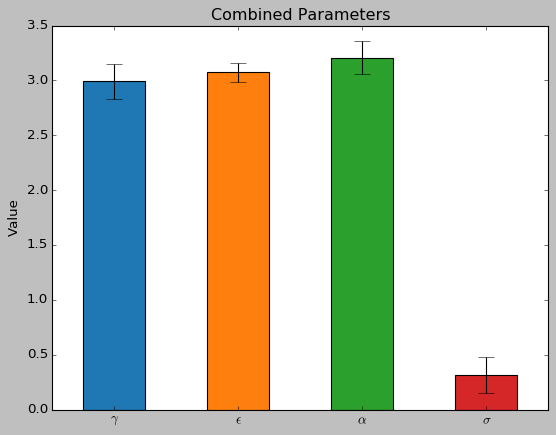

In [105]:
plotting_params(combined_params, pic_name = 'params_cols', style_label= 'classic')

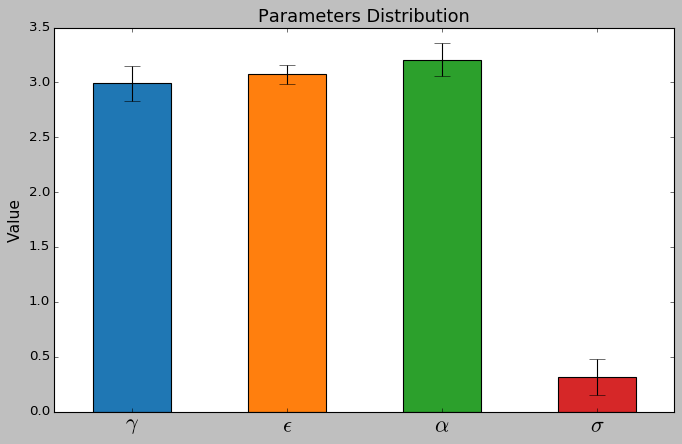

In [106]:

# Plotting function for combined parameters
def plotting_params_2(parameters: np.ndarray, barWidth=0.5, style_label = 'seaborn-darkgrid', 
                      saving_plot = True, folder_name = 'fitted_pics', 
                      pic_name = 'params'):
    # Choose the height of the bars
    bars1 = np.nanmean(parameters, axis=0)
 
    # Choose the height of the error bars (bars1)
    yer1 = 2 * np.nanstd(parameters, axis=0)
 
    # The x position of bars
    r1 = np.arange(len(bars1))

    # Configure matplotlib to use LaTeX for rendering
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    
    # Use a different style
    plt.style.use(style_label)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))  # create figure & 1 axis

    # Customizing the bar colors
    bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Create bars
    ax.bar(r1, bars1, width=barWidth, color=bar_colors, edgecolor='black', yerr=yer1, capsize=7)
    
    # General layout
    plt.xticks(r1, [r'$\gamma$', r'$\epsilon$', r'$\alpha$', r'$\sigma$'], fontsize=20)
    plt.ylabel(r'Value', fontsize=14)
    plt.title(r'Parameters Distribution', fontsize=16)
    
    # Adding grid lines
    #plt.grid(False, which='both', linestyle='--', linewidth=0.5)
    
    if saving_plot:
        
        current_dir = os.getcwd()
        parent_dir = os.path.dirname(current_dir)
        data_folder = os.path.join(parent_dir, folder_name)
        if not os.path.exists(data_folder):
            os.makedirs(data_folder) 
        
        # Save the figure with a specific name based on the cluster
        filename = f'{pic_name}.png'
        filepath = os.path.join(data_folder, filename)
        plt.savefig(filepath)
    
    
    plt.show()
    
plotting_params_2(combined_params, pic_name = 'params_5', style_label= 'classic')

In [46]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


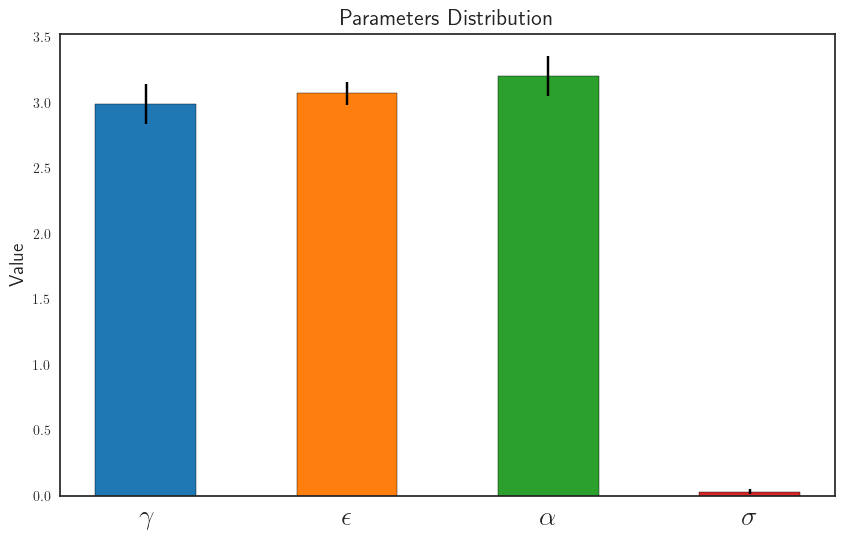

In [78]:
plotting_params_2(combined_params, style_label= 'seaborn-v0_8-white', 
                  saving_plot = True, folder_name = 'fitted_pics', 
                    pic_name = 'params_4')

### Statistical Tests for Gaussianity

**Shapiro-Wilk Test**: the Shapiro-Wilk test (`scipy.stats.shapiro`) can be used to test each parameter's distribution for normality.
- Null hypothesis (H0): The distribution is normal.
- Alternative hypothesis (H1): The distribution is not normal.

**P-value Interpretation**: For each parameter, interpret the Shapiro-Wilk test's p-value:
- If p-value > 0.05, accept the null hypothesis (distribution is likely normal).
- If p-value <= 0.05, reject the null hypothesis (distribution is not normal).


In [107]:
from scipy.stats import norm, shapiro

# Statistical tests for Gaussianity (Shapiro-Wilk test)
def test_gaussianity(parameters: np.ndarray):
    num_params = parameters.shape[1]  # Number of parameters (should be 4)
    p_values = []

    print('Shapiro-Wilk Test Results:')
    for i in range(num_params):
        param_values = parameters[:, i]
        _, p_value = shapiro(param_values)
        p_values.append(p_value)
        print(f'Parameter {i+1}: p-value = {p_value:.4f}')

    return p_values

In [108]:
# Perform statistical tests
p_values = test_gaussianity(combined_params)


Shapiro-Wilk Test Results:
Parameter 1: p-value = 0.0000
Parameter 2: p-value = 0.0000
Parameter 3: p-value = 0.0000
Parameter 4: p-value = 0.0000


In [109]:
# Interpret p-values
for i, p_value in enumerate(p_values):
    if p_value > 0.05:
        print(f'Parameter {i+1} is likely normally distributed (p-value={p_value:.10f})')
    else:
        print(f'Parameter {i+1} is not normally distributed (p-value={p_value:.10f})')

Parameter 1 is not normally distributed (p-value=0.0000000009)
Parameter 2 is not normally distributed (p-value=0.0000016472)
Parameter 3 is not normally distributed (p-value=0.0000000002)
Parameter 4 is not normally distributed (p-value=0.0000029193)


In [122]:
def plot_gaussian_distributions(parameters: np.ndarray, 
                                style_label ='seaborn-whitegrid', 
                                saving_plot = True,    folder_name = 'fitted_pics', 
                                pic_name = 'params_gaussian'):
    
    num_params = parameters.shape[1]  # Number of parameters (should be 4)
    plt.style.use(style_label) 
    titles = ['$\gamma (s^{-1})$', '$\varepsilon (m^3 kg^2 s^{-4}$', '$\alpha (kg^{-1})$', '$\sigma$']
    #parameters_label = ['$\gamma$', '$\epsilon$', '$\alpha$', '$\sigma$']
    parameters_label = [r'$\gamma$', r'$\epsilon$', r'$\alpha$', r'$\sigma$'] 
    # Create figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

    # Plotting Gaussian distributions for each parameter
    for i in range(num_params):
        mean = np.mean(parameters[:, i])
        std_dev = np.std(parameters[:, i])
        
        # Generate x values for the plot
        x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 100)
        # Calculate Gaussian pdf
        y = norm.pdf(x, mean, std_dev)
        
        # Plot the Gaussian distribution
        #ax.plot(x, y, label=f'Parameter {i+1}: $\mu$={mean:.2f}, $\sigma$={std_dev:.2f}')
        ax.plot(x, y, label=f'{parameters_label[i]}: $\mu$={mean:.2f}, $std$={std_dev:.2f}')

    # Add labels, title, legend
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title('Gaussian Distributions of Parameters')
    ax.legend(loc = 2)

    if saving_plot:
        
        current_dir = os.getcwd()
        parent_dir = os.path.dirname(current_dir)
        data_folder = os.path.join(parent_dir, folder_name)
        if not os.path.exists(data_folder):
            os.makedirs(data_folder) 
        
        # Save the figure with a specific name based on the cluster
        filename = f'{pic_name}.png'
        filepath = os.path.join(data_folder, filename)
        plt.savefig(filepath)
        
    # Show plot
    plt.show()


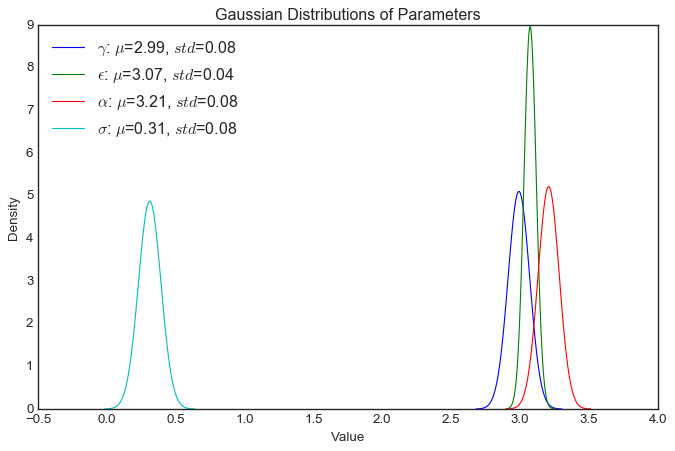

In [123]:
plot_gaussian_distributions(combined_params, pic_name='gaussians_', style_label='seaborn-v0_8-white')


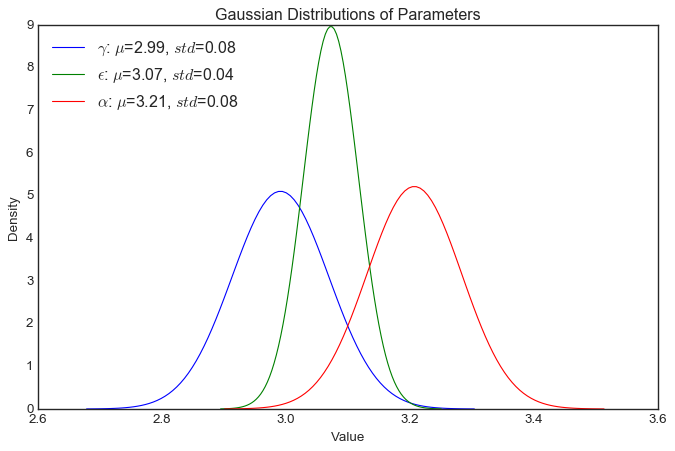

In [124]:
plot_gaussian_distributions(combined_params[:, :3], pic_name='gaussians_2', style_label='seaborn-v0_8-white')

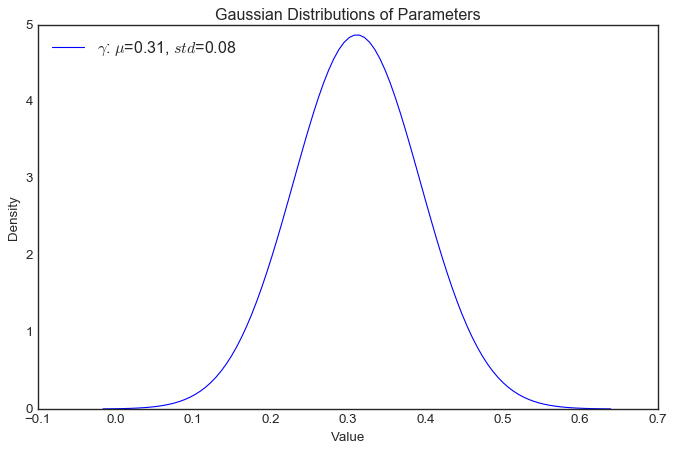

In [125]:
plot_gaussian_distributions(combined_params[:, 3:], pic_name='gaussians_sig', style_label='seaborn-v0_8-white')

In [142]:
from scipy import stats

# Plotting Gaussian distributions for the first three parameters
def plot_gaussian_distributions_theo(parameters: np.ndarray, style_label ='seaborn-whitegrid', 
                                     saving_plot = True,    folder_name = 'fitted_pics', 
                                     pic_name = 'params_gaussian', 
                                     ):
    num_params = parameters.shape[1]  # Number of parameters (should be 4)
    titles = [r'$\gamma (s^{-1})$', r'$\varepsilon (m^3 kg^2 s^{-4})$', r'$\alpha (kg^{-1})$', r'$\sigma$']
    titles_ = [r'$\gamma $', r'$\varepsilon$', r'$\alpha$', r'$\sigma$']
     
    plt.style.use(style_label)  
    
    fig, axs = plt.subplots(nrows=1, ncols=num_params, figsize=(18, 6))
    bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for i in range(num_params):
        ax = axs[i]
        param_values = parameters[:, i]
        mean = np.mean(param_values)
        std_dev = np.std(param_values)
        
        # Generate x values for the plot
        x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 100)
        # Calculate Gaussian pdf
        y = norm.pdf(x, mean, std_dev)
        
        T_test = stats.ttest_ind(y, param_values, trim=.2)
        print(titles[i])
        print('T-test results: ', T_test)
        
        # Perform Shapiro-Wilk test for Gaussianity
        shapiro_test = shapiro(param_values)
        print(titles[i])
        print('Shapiro-Wilk test results:', shapiro_test)
        
        
        
        # Plot the Gaussian distribution
        ax.plot(x, y, color = 'black', label=f'Theoretical Gaussian: $\mu$={mean:.2f}, $std$={std_dev:.2f}')
        ax.hist(param_values, histtype='stepfilled', bins=20, color = bar_colors[i], density=True, alpha=0.7, label='Experimental distribution')
        
        #ax.set_title(f'Parameter {i+1}')
        ax.set_title(titles[i])
        ax.set_xlabel(titles_[i])
         
        #ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend(loc = 2, fontsize = 10)

    plt.tight_layout()
    
    if saving_plot:
        
        current_dir = os.getcwd()
        parent_dir = os.path.dirname(current_dir)
        data_folder = os.path.join(parent_dir, folder_name)
        if not os.path.exists(data_folder):
            os.makedirs(data_folder) 
        
        # Save the figure with a specific name based on the cluster
        filename = f'{pic_name}.png'
        filepath = os.path.join(data_folder, filename)
        plt.savefig(filepath)
        
    plt.show()

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-13.027006863757286, pvalue=2.4459607188967322e-29)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9344421625137329, pvalue=8.867243050936224e-10)
$\varepsilon (m^3 kg^2 s^{-4})$
T-test results:  Ttest_indResult(statistic=-4.501598487361625, pvalue=1.0780131371863227e-05)
$\varepsilon (m^3 kg^2 s^{-4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9634361267089844, pvalue=1.6472025663460954e-06)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-14.185414014232984, pvalue=3.975377753606875e-33)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9266099333763123, pvalue=1.6788802292833083e-10)
$\sigma$
T-test results:  Ttest_indResult(statistic=5.329043578778999, pvalue=2.3767986177548851e-07)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9652557969093323, pvalue=2.9193408863648074e-06)


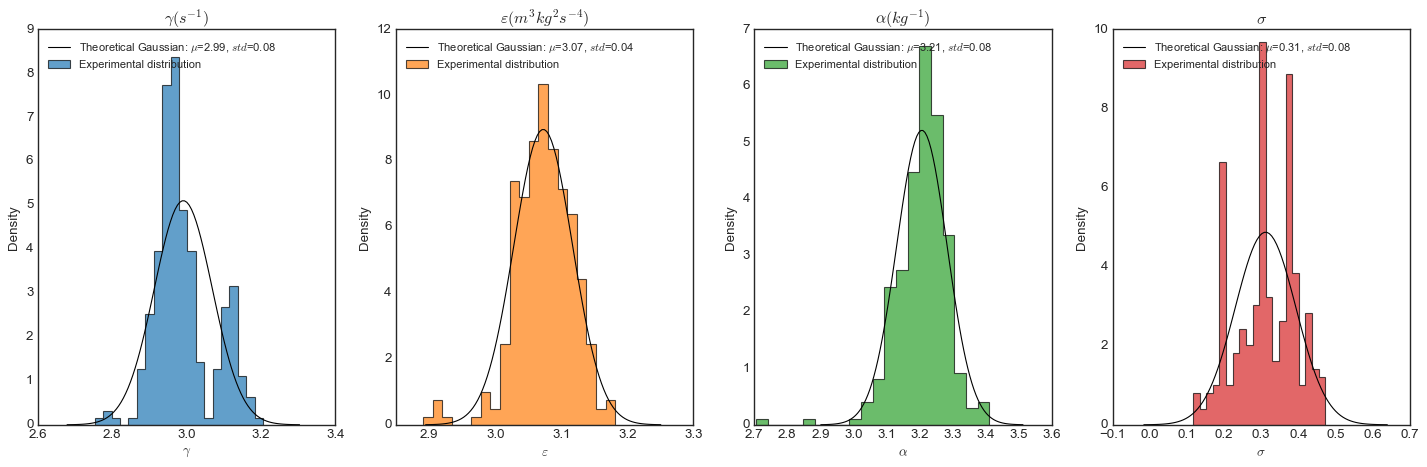

In [143]:
plot_gaussian_distributions_theo(combined_params, pic_name='params_gaussian_all_ttest_3', style_label='seaborn-v0_8-white')

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=-13.027006863757286, pvalue=2.4459607188967322e-29)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9344421625137329, pvalue=8.867243050936224e-10)
$\varepsilon (m^3 kg^2 s^{-4})$
T-test results:  Ttest_indResult(statistic=-4.501598487361625, pvalue=1.0780131371863227e-05)
$\varepsilon (m^3 kg^2 s^{-4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9634361267089844, pvalue=1.6472025663460954e-06)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=-14.185414014232984, pvalue=3.975377753606875e-33)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9266099333763123, pvalue=1.6788802292833083e-10)


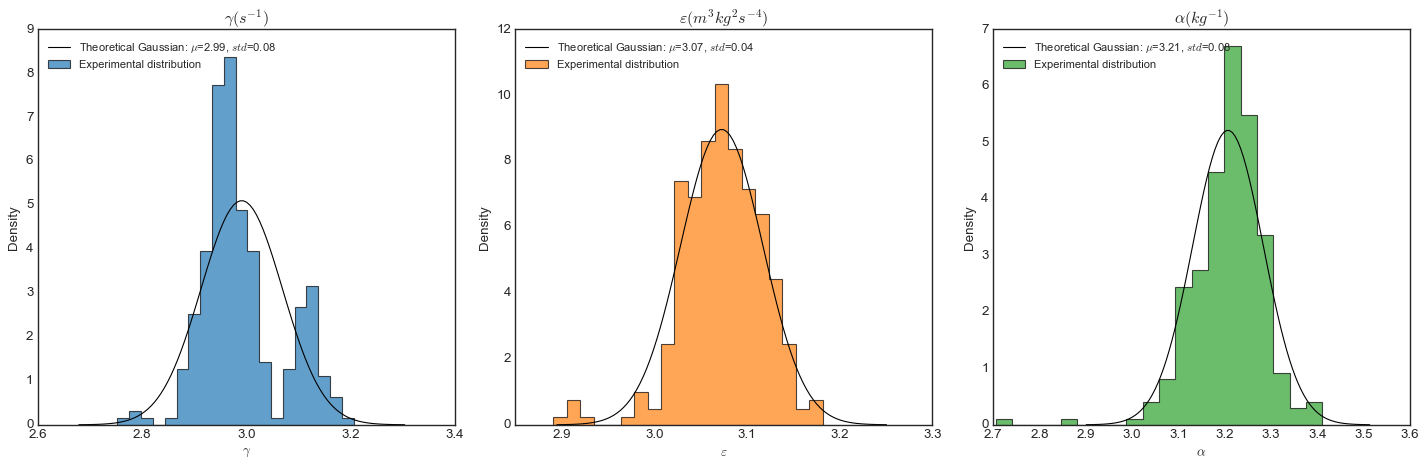

In [144]:
plot_gaussian_distributions_theo(combined_params[:, :3], style_label = 'seaborn-v0_8-white', pic_name='params_gaussian_all_ttest_4')

In [147]:
import seaborn as sns

def box_plot_params(parameters: np.ndarray, style_label ='seaborn-whitegrid', 
                                     saving_plot = True,    folder_name = 'fitted_pics', 
                                     pic_name = 'params_gaussian', 
                                     ):
    num_params = parameters.shape[1]  # Number of parameters (should be 4)
    titles = [r'$\gamma (s^{-1})$', r'$\varepsilon (m^3 kg^2 s^{-4})$', r'$\alpha (kg^{-1})$', r'$\sigma$']
    titles_ = [r'$\gamma $', r'$\varepsilon$', r'$\alpha$', r'$\sigma$']
     
    plt.style.use(style_label)  
    
    fig, axs = plt.subplots(nrows=1, ncols=num_params, figsize=(18, 6))
    bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i in range(num_params):
        ax = axs[i]
        param_values = parameters[:, i]
        mean = np.mean(param_values)
        std_dev = np.std(param_values)
        
        sns.boxplot(y=param_values, ax=ax, color=bar_colors[i])
        ax.set_title(titles[i])
        ax.set_xlabel(titles_[i])
         
        #ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        #ax.legend(loc = 2, fontsize = 10)

    plt.tight_layout()
    
    if saving_plot:
        
        current_dir = os.getcwd()
        parent_dir = os.path.dirname(current_dir)
        data_folder = os.path.join(parent_dir, folder_name)
        if not os.path.exists(data_folder):
            os.makedirs(data_folder) 
        
        # Save the figure with a specific name based on the cluster
        filename = f'{pic_name}.png'
        filepath = os.path.join(data_folder, filename)
        plt.savefig(filepath)
        
    plt.show()

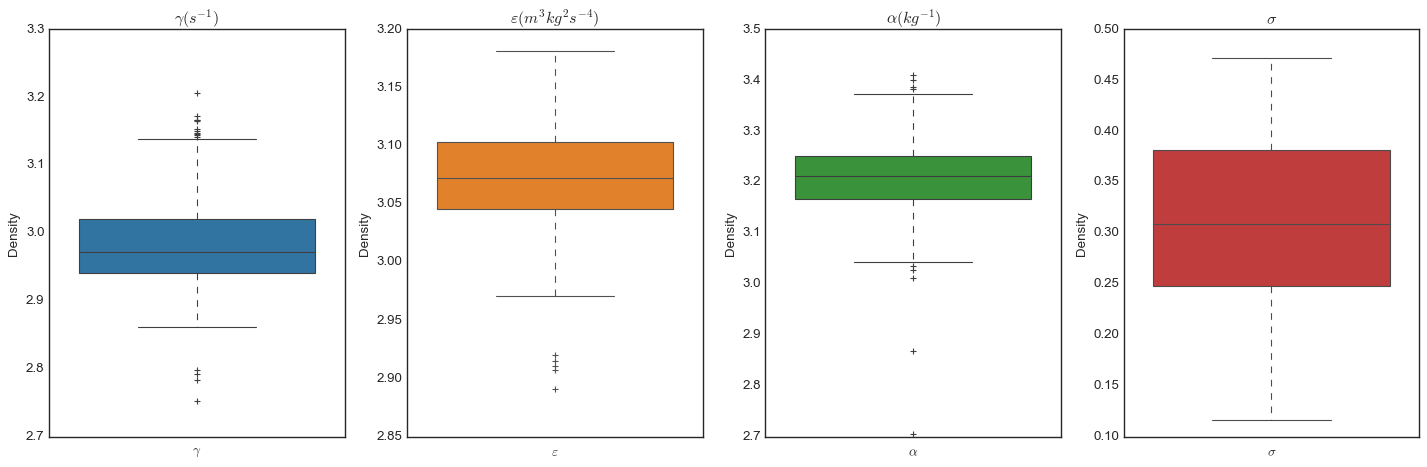

In [148]:
box_plot_params(parameters = combined_params, style_label ='seaborn-v0_8-white', 
                                     saving_plot = True,    folder_name = 'fitted_pics', 
                                     pic_name = 'params_boxplot') 
                                     